In [22]:
import torch
from torch import nn

from model.common.ConvBlocks import Conv1dBlock, ConditionalResidualBlock1D, Downsample1d, Upsample1d
from model.common.SinusoidalPosEmbedding import SinusoidalPosEmb
from model.diffusion.conditional_unet_1d import ConditionalUnet1D

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

import numpy as np
import os
import gdown
from env.envData import PushTStateDataset

# Visualizamos los datos con el visualizador
import matplotlib.pyplot as plt


from tqdm import tqdm

import matplotlib.pyplot as plt


In [23]:
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256
)

dict_keys(['action', 'obs'])
[[-0.13591051 -0.73197037 -0.13439745  0.44849265 -0.04254496]
 [-0.13591051 -0.73197037 -0.13439745  0.44849265 -0.04254496]]
(2, 5)
(16, 2)
(2, 5)


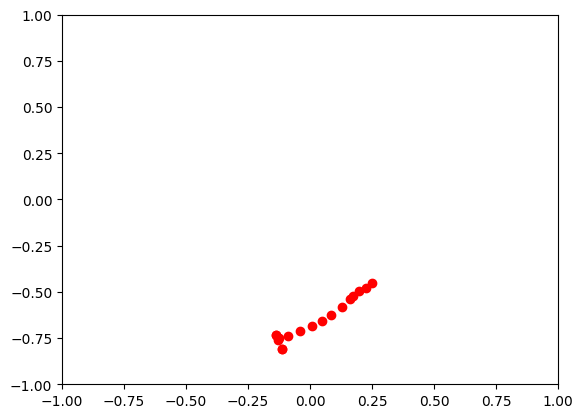

(2, 5)


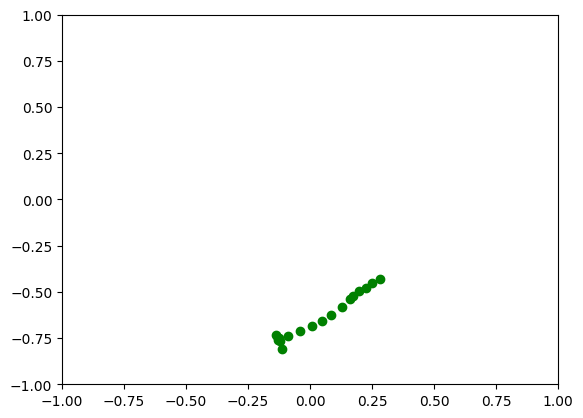

(2, 5)


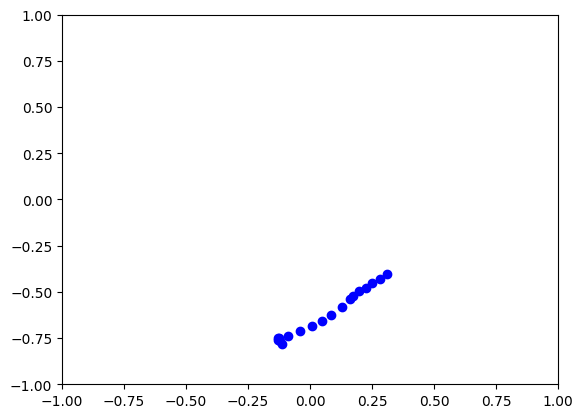

(2, 5)


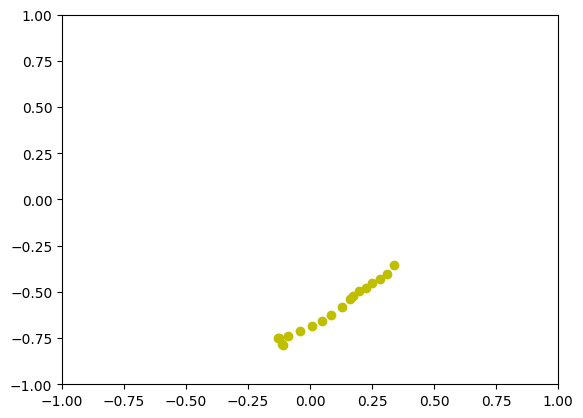

(2, 5)


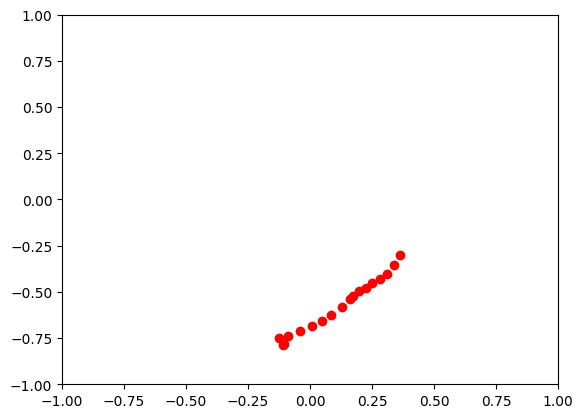

(2, 5)


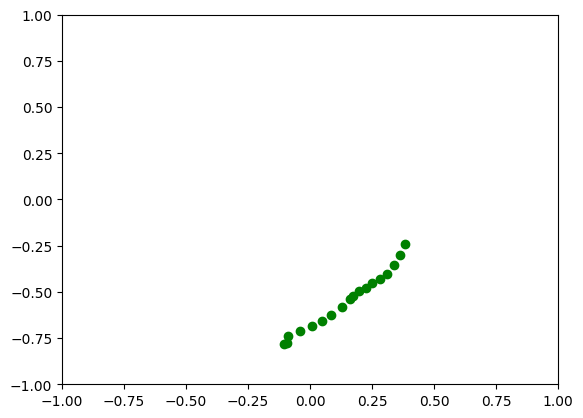

In [24]:
# Visualizamos los datos
for batch in dataset:
    print (batch.keys())
    obs = batch["obs"]
    print (obs)
    print (obs.shape)
    actions = batch["action"]
    print (actions.shape)
    break

# Visualizamos los datos en su forma original
counter = 0
colors = ['r', 'g', 'b', 'y']
for batch in dataset:
    obs = batch["obs"]
    print (obs.shape)
    actions = batch["action"]
    plt.scatter(obs[:,0], obs[:,1], c=colors[counter % 4])
    plt.scatter(actions[:,0], actions[:,1], c=colors[counter % 4])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    if counter == 5:
        break
    counter += 1
    plt.show()


In [34]:
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

dict_keys(['action', 'obs'])
torch.Size([256, 2, 5])
torch.Size([256, 2, 5])
torch.Size([256, 10])
torch.Size([256, 16, 2])
100
torch.Size([256])
torch.Size([256, 16, 2])


ValueError: 'c' argument has 256 elements, which is inconsistent with 'x' and 'y' with size 512.

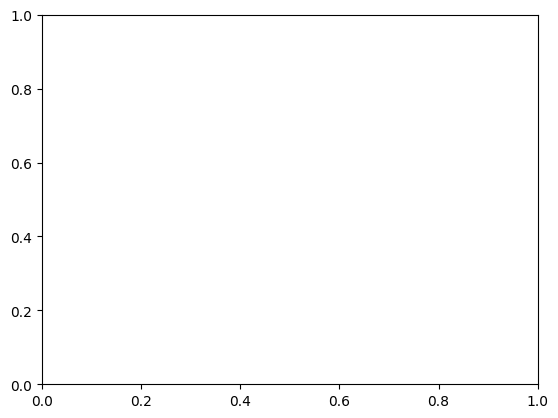

In [41]:
# for batch
for batch in dataloader:
    print (batch.keys())
    obs = batch["obs"]
    naction = batch["action"]
    print (obs.shape)
    B = obs.shape[0]
    obs_cond = obs[:, :obs_horizon,:]
    print (obs_cond.shape)
    obs_pred = obs_cond.flatten(start_dim=1)
    print (obs_pred.shape)
    noise = torch.randn(naction.shape)
    print (noise.shape)
    print (noise_scheduler.config.num_train_timesteps)
    timesteps = torch.randint(
        0, noise_scheduler.config.num_train_timesteps, (B,)
    ).long()
    print (timesteps.shape)
    noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)
    #noisy_pred = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)
    print (noisy_actions.shape)
    # Visualizamos los datos originales y los datos con ruido
    plt.scatter(naction[:,0], naction[:,1], c=timesteps)
    plt.scatter(noisy_actions[:,0], noisy_actions[:,1], c=timesteps)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()
    break